# $\mathrm{NO_3}$

In [131]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [132]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [133]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [134]:
h5_path = "../../data/photolysis_data.h5" 
species = "NO3" 
rxns = relevant_rxns(h5_path, species)

8-element Vector{Any}:
 "BrONO2  to  Br and NO3"
 "ClONO2  to  Cl and NO3"
 "IONO2  to  I and NO3"
 "N2O5  to  NO3 and NO and O(3P)"
 "N2O5  to  NO3 and NO2"
 "NO3  to  NO and O2"
 "NO3  to  NO2 and O"
 "NO3  to  total"

In [135]:
rxn1 = rxns[end-2]
rxn2 = rxns[end-1]

"NO3  to  NO2 and O"

There are two pathways for the decomposition that correspond to photolysis rates $J_5$ and $J_6$ in the MCM, respectively. We will therefore do a fit for both

In [136]:
rxn = rxn1
λs, Φs, T1s, T2s, species, source_idx, T_units, category, reaction, λ_units, Φ_units  = get_raw_data(h5_path, rxn)

([586.0, 587.0, 588.0, 589.0, 590.0, 591.0, 592.0, 593.0, 594.0, 595.0  …  630.0, 631.0, 632.0, 633.0, 634.0, 635.0, 636.0, 637.0, 638.0, 639.0], [0.0379, 0.0944, 0.221, 0.283, 0.397, 0.448, 0.495, 0.575, 0.61, 0.63  …  0.078, 0.07, 0.062, 0.054, 0.047, 0.039, 0.031, 0.023, 0.016, 0.008], [190.0, 230.0, 298.0, 296.0, 298.0, 296.0], [NaN, NaN, NaN, NaN, NaN, NaN], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  6, 6, 6, 6, 6, 6, 6, 6, 6, 6], "K", "Nitrogen oxides", "NO3 → NO+O2", "nm", "")

Based on the mcm Photolysis entry for $\mathrm{O_3}$, it appears we want the quantum yields for the production of $\mathrm{O(^1D)}$. The rate for $\mathrm{O(^3P)}$ is then defined as $1.0$ minus the $\mathrm{O(^1D)}$ rate [(based on this data)](http://chmlin9.leeds.ac.uk/MCMv3.3.1/parameters/photolysis/O3/o3_o3p_matsumi02_qy_298.txt).

In [137]:
unique(species)

2-element Vector{Int64}:
 1
 2

In [138]:
reaction

"NO3 → NO+O2"

In [139]:
species_to_use = 1 
df = data_to_df(λs, Φs, T1s, T2s, source_idx, species, species_to_use)

169×4 DataFrame
 Row │ λ        Φ        T        source_id 
     │ Float64  Float64  Float64  Int64     
─────┼──────────────────────────────────────
   1 │   586.0   0.0152    298.0          3
   2 │   587.0   0.0391    298.0          3
   3 │   588.0   0.0971    298.0          3
   4 │   589.0   0.128     298.0          3
   5 │   590.0   0.19      298.0          3
   6 │   591.0   0.22      298.0          3
   7 │   592.0   0.249     298.0          3
   8 │   593.0   0.303     298.0          3
   9 │   594.0   0.328     298.0          3
  10 │   595.0   0.359     298.0          3
  11 │   596.0   0.357     298.0          3
  ⋮  │    ⋮        ⋮        ⋮         ⋮
 160 │   630.0   0.078     296.0          6
 161 │   631.0   0.07      296.0          6
 162 │   632.0   0.062     296.0          6
 163 │   633.0   0.054     296.0          6
 164 │   634.0   0.047     296.0          6
 165 │   635.0   0.039     296.0          6
 166 │   636.0   0.031     296.0          6
 167 │   637.0   0.023     296.0          6
 168 │   638.0   0.016     296.0          6
 169 │   639.0   0.008     296.0          6
                            148 rows omitted

In [140]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [141]:
unique(df.T)
unique(df.source_id)

n_sources = size(unique(df.source_id),1)

source_colors = distinguishable_colors(n_sources)

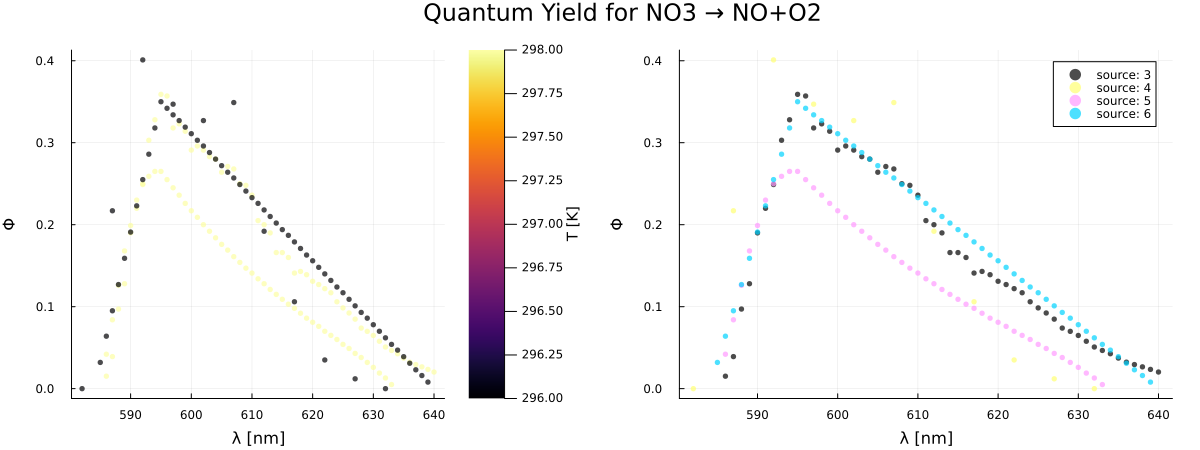

In [142]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    df.Φ[1:nskip:end],
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


gdf = groupby(df, :source_id)
p3 = plot()
i = 1
for df_g ∈ gdf 
    scatter!(
        df_g.λ[1:nskip:end],
        df_g.Φ[1:nskip:end],
        color = source_colors[i],
        ms=3, 
        msw=0,
        xlabel="λ [$(λ_units)]",
        ylabel="Φ",
        alpha=0.7,
        label="source: $(df_g.source_id[1])",
    )
    i += 1 
end

plot(p2, p3, layout=(1,2), size=(1200, 450), margin=5Plots.mm, plot_title="Quantum Yield for $(reaction)",)

In [143]:
df = df[df.source_id .!= 4 .&& df.source_id .!= 5, :]

110×4 DataFrame
 Row │ λ        Φ        T        source_id 
     │ Float64  Float64  Float64  Int64     
─────┼──────────────────────────────────────
   1 │   586.0   0.0152    298.0          3
   2 │   587.0   0.0391    298.0          3
   3 │   588.0   0.0971    298.0          3
   4 │   589.0   0.128     298.0          3
   5 │   590.0   0.19      298.0          3
   6 │   591.0   0.22      298.0          3
   7 │   592.0   0.249     298.0          3
   8 │   593.0   0.303     298.0          3
   9 │   594.0   0.328     298.0          3
  10 │   595.0   0.359     298.0          3
  11 │   596.0   0.357     298.0          3
  ⋮  │    ⋮        ⋮        ⋮         ⋮
 101 │   630.0   0.078     296.0          6
 102 │   631.0   0.07      296.0          6
 103 │   632.0   0.062     296.0          6
 104 │   633.0   0.054     296.0          6
 105 │   634.0   0.047     296.0          6
 106 │   635.0   0.039     296.0          6
 107 │   636.0   0.031     296.0          6
 108 │   637.0   0.023     296.0          6
 109 │   638.0   0.016     296.0          6
 110 │   639.0   0.008     296.0          6
                             89 rows omitted

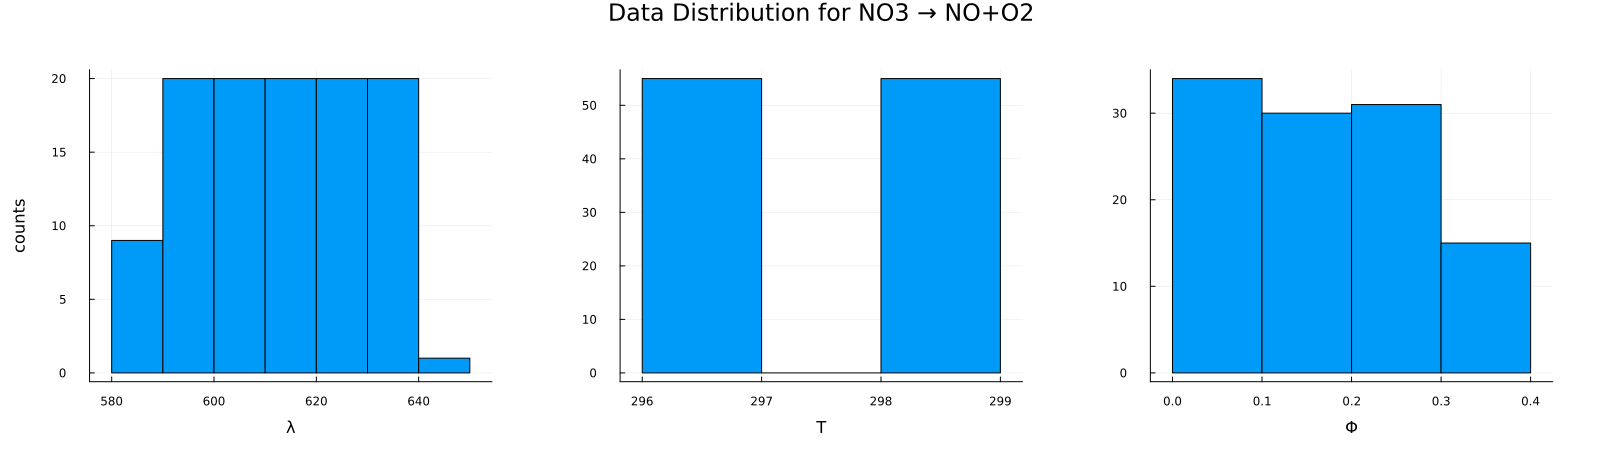

In [144]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(df.Φ, xlabel="Φ", label="", margin=10Plots.mm)
phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(reaction)")

# Data Preprocessing

In [145]:
gdfs = groupby(df, :T)

res_dfs = [] 

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:Φ, :T] .=> mean, renamecols=false))
end

df_unique = vcat(res_dfs...)

110×3 DataFrame
 Row │ λ        Φ        T       
     │ Float64  Float64  Float64 
─────┼───────────────────────────
   1 │   585.0   0.032     296.0
   2 │   586.0   0.064     296.0
   3 │   587.0   0.095     296.0
   4 │   588.0   0.127     296.0
   5 │   589.0   0.159     296.0
   6 │   590.0   0.191     296.0
   7 │   591.0   0.223     296.0
   8 │   592.0   0.255     296.0
   9 │   593.0   0.286     296.0
  10 │   594.0   0.318     296.0
  11 │   595.0   0.35      296.0
  ⋮  │    ⋮        ⋮        ⋮
 101 │   631.0   0.0578    298.0
 102 │   632.0   0.0508    298.0
 103 │   633.0   0.0466    298.0
 104 │   634.0   0.0426    298.0
 105 │   635.0   0.0373    298.0
 106 │   636.0   0.0323    298.0
 107 │   637.0   0.0294    298.0
 108 │   638.0   0.0266    298.0
 109 │   639.0   0.0235    298.0
 110 │   640.0   0.0203    298.0
                  89 rows omitted

In [146]:
# λ_idxs = representative_rand_sample(df_unique.λ, 1000, 1500)
# Φ_idxs = representative_rand_sample(df_unique.Φ, 500, 2000) 
# idxs_res = shuffle(unique(vcat(λ_idxs, σ_idxs)))
# df_sampled = df_unique[idxs_res, :]

df_sampled = df_unique
max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

585.0

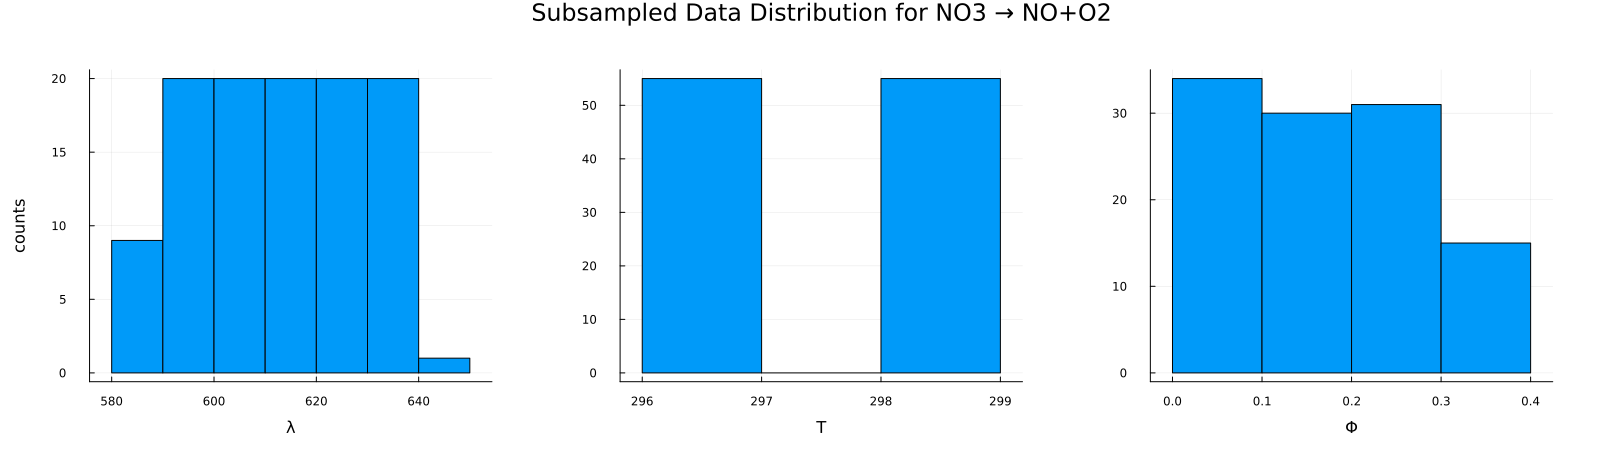

In [147]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(df_sampled.Φ, xlabel="Φ", label="", margin=10Plots.mm)

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(reaction)")

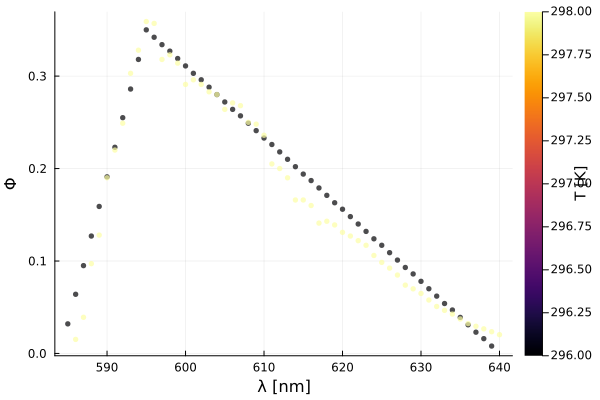

In [148]:
p2 = scatter(
    df_sampled.λ,
    df_sampled.Φ,
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


# GPR Fit

In [149]:
train_frac = 0.90
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

99


In [150]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = df_sampled.Φ[idxs_train]
ytest = df_sampled.Φ[idxs_test]

11-element Vector{Float64}:
 0.255
 0.236
 0.148
 0.291
 0.291
 0.296
 0.16
 0.249
 0.0373
 0.171
 0.205

In [151]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain.λ)/κ
ℓ_T = std(Xtrain.T)/κ

# compute variance parameters
SNR = 5 
σf² = var(ytrain)
σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))

# copying from previous best-fit
θ_init = (σf²=positive(0.017615227486105476), ℓ_λ=positive(6.077990880938322), ℓ_T=positive(9.122288770316391))
σₙ² = 3.633641300025815e-5


function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

mykernel (generic function with 1 method)

In [152]:
μ_init = 0.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = 0.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-4.038992398857315, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(1.8046741917026135, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(2.2107207326246407, exp, 1.4901161193847656e-8)), 
  σ² = 3.633641300025815e-5, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [153]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = 0.0, …), …).


Iter     Function value   Gradient norm 
     0    -3.073370e+02     3.509132e+00
 * time: 0.0002601146697998047
     1    -3.074478e+02     1.863352e+00
 * time: 0.009984016418457031
     2    -3.075246e+02     5.786483e-01
 * time: 0.018481016159057617
     3    -3.075281e+02     1.776581e-01
 * time: 0.028087139129638672
     4    -3.075297e+02     8.380834e-02
 * time: 0.039578914642333984
     5    -3.075302e+02     9.618701e-02
 * time: 0.04801511764526367
     6    -3.075303e+02     3.470242e-04
 * time: 0.05765104293823242
     7    -3.075303e+02     3.666017e-06
 * time: 0.06531691551208496
     8    -3.075303e+02     2.237062e-08
 * time: 0.07509708404541016
     9    -3.075303e+02     2.497685e-08
 * time: 0.08083701133728027
    10    -3.075303e+02     8.024613e-08
 * time: 0.0922391414642334
    11    -3.075303e+02     5.389050e-08
 * time: 0.10091304779052734
    12    -3.075303e+02     1.513570e-07
 * time: 0.11042594909667969
    13    -3.075303e+02     7.663551e-08
 * 

trained Machine; caches model-specific representations of data
  model: GPR(μ = 0.0, …)
  args: 
    1:	Source @142 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @605 ⏎ AbstractVector{Continuous}


# Model Evaluation for pathway 1

In [154]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [-4.023186934784984, 1.8066142586758287, 2.2355561786854192, -10.327725749910078],
 minimum = -307.5302831873914,
 iterations = 46,
 converged = true,)

In [155]:
fp =fitted_params(mach)

(θ_best = [:σf² => 0.017895855985553658, :ℓ_λ => 6.089794036034598, :ℓ_T => 9.351681626951406],
 σ² = 3.272830208232441e-5,)

In [156]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

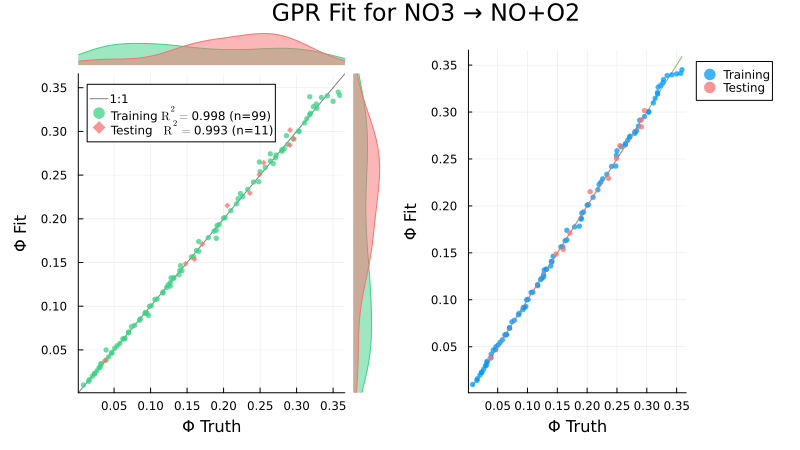

In [157]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="Φ Truth",
    ylabel="Φ Fit",
)

p2 = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="Φ Truth",
    ylabel="Φ Fit",
)

plot(p, p2, layout=(1,2), size=(800, 450), plot_title="GPR Fit for $(reaction)", margins=5Plots.mm)

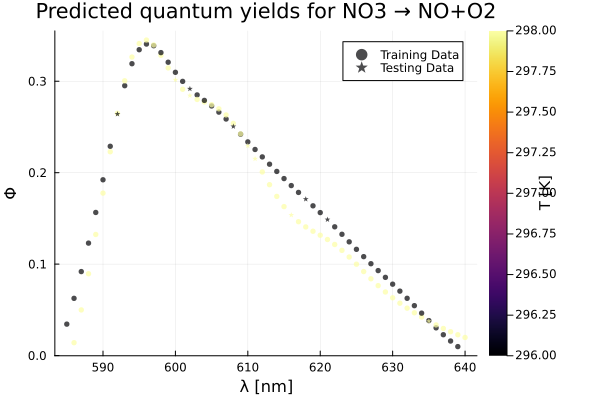

In [158]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted quantum yields for $(reaction)",
    label="Testing Data",
)


585.0
640.0


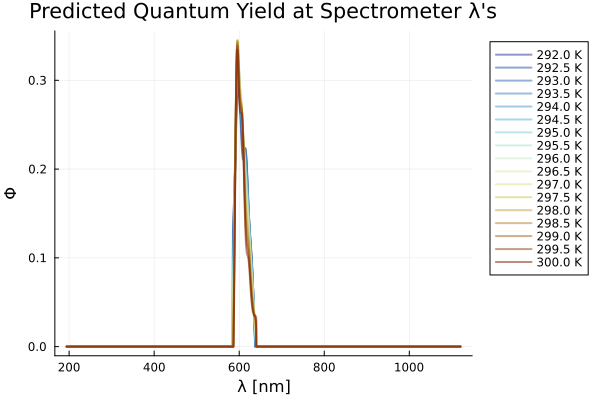

In [159]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1

for T ∈ Ts
    logΦ = predict_Φ(T, hr4000_df, mach, (λ_min, λ_max))
   
    # update for any prediction above 1.0 or below 0.0
    idx_one = [idx for idx ∈ 1:size(logΦ,1) if logΦ[idx] > 1.0]
    logΦ[idx_one] .= 1.0

    idx_zero = [idx for idx ∈ 1:size(logΦ,1) if logΦ[idx] < 0.0]
    logΦ[idx_zero] .= 0.0
    
    plot!(
        hr4000_df.λ, logΦ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end


xlabel!("λ [nm]")
ylabel!("Φ")
title!("Predicted Quantum Yield at Spectrometer λ's")

# Output for Photolysis Rate Determination

In [160]:
df_photolysis_Φ = CSV.File("../photolysis_Φ.csv") |> DataFrame

3648×6 DataFrame
  Row │ Φ_1      Φ_2      Φ_3      Φ_4      Φ_6      Φ_5     
      │ Float64  Float64  Float64  Float64  Float64  Float64 
──────┼──────────────────────────────────────────────────────
    1 │     1.0      0.0      0.0      1.0      1.0      1.0
    2 │     1.0      0.0      0.0      1.0      1.0      1.0
    3 │     1.0      0.0      0.0      1.0      1.0      1.0
    4 │     1.0      0.0      0.0      1.0      1.0      1.0
    5 │     1.0      0.0      0.0      1.0      1.0      1.0
    6 │     1.0      0.0      0.0      1.0      1.0      1.0
    7 │     1.0      0.0      0.0      1.0      1.0      1.0
    8 │     1.0      0.0      0.0      1.0      1.0      1.0
    9 │     1.0      0.0      0.0      1.0      1.0      1.0
   10 │     1.0      0.0      0.0      1.0      1.0      1.0
   11 │     1.0      0.0      0.0      1.0      1.0      1.0
  ⋮   │    ⋮        ⋮        ⋮        ⋮        ⋮        ⋮
 3639 │     0.0      1.0      1.0      0.0      0.0      0.0
 3640 │     0.0      1.0      1.0      0.0      0.0      0.0
 3641 │     0.0      1.0      1.0      0.0      0.0      0.0
 3642 │     0.0      1.0      1.0      0.0      0.0      0.0
 3643 │     0.0      1.0      1.0      0.0      0.0      0.0
 3644 │     0.0      1.0      1.0      0.0      0.0      0.0
 3645 │     0.0      1.0      1.0      0.0      0.0      0.0
 3646 │     0.0      1.0      1.0      0.0      0.0      0.0
 3647 │     0.0      1.0      1.0      0.0      0.0      0.0
 3648 │     0.0      1.0      1.0      0.0      0.0      0.0
                                            3627 rows omitted

In [161]:
λ_min = minimum(df_sampled.λ)
λ_max = maximum(df_sampled.λ)

#println(λ_min, "\t", minimum(df_photolysis_σ.λ))
#println(λ_max, "\t", maximum(df_photolysis_σ.λ))

640.0

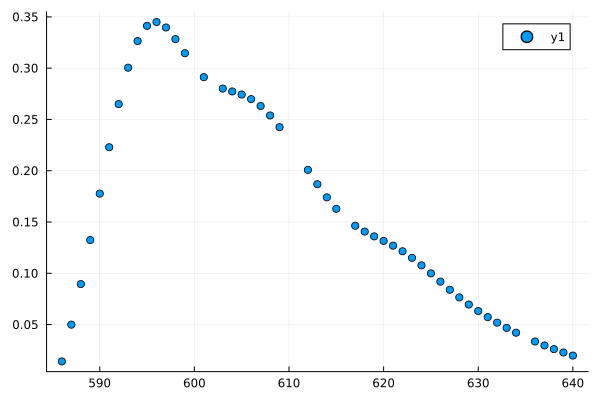

In [162]:
df_pred = sort!(Xtrain[Xtrain.T .== 298.0, :], :λ)
Φ_pred = predict_mean(mach, df_pred);

scatter(df_pred.λ, Φ_pred)

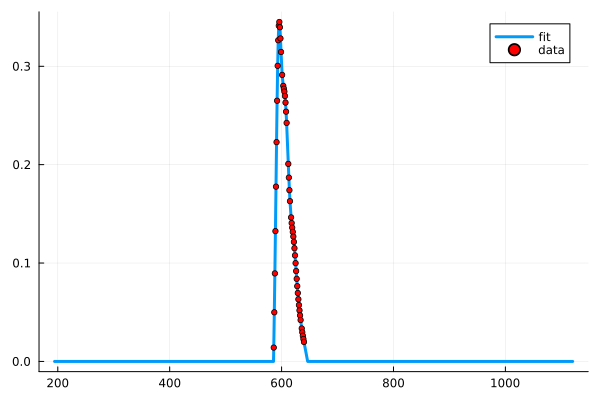

In [163]:
using DataInterpolations

cs = LinearInterpolation(Φ_pred, df_pred.λ)
Φ_out = cs(hr4000_df.λ)

# set anything outside of λ range to 0 as well
Φ_out[Φ_out .< 0.0] .= 0.0
Φ_out[hr4000_df.λ .≤ λ_min .&& hr4000_df.λ .≥ λ_max] .= 0.0


plot(hr4000_df.λ, Φ_out, lw=3, label="fit")
scatter!(df_pred.λ, Φ_pred, color=:red, ms=3, label="data")

In [164]:
df_photolysis_Φ.Φ_5 = Φ_out

describe(df_photolysis_Φ)

6×7 DataFrame
 Row │ variable  mean        min      median   max       nmissing  eltype   
     │ Symbol    Float64     Float64  Float64  Float64   Int64     DataType 
─────┼──────────────────────────────────────────────────────────────────────
   1 │ Φ_1       0.114981        0.0      0.0  1.0              0  Float64
   2 │ Φ_2       0.885019        0.0      1.0  1.0              0  Float64
   3 │ Φ_3       0.963542        0.0      1.0  1.0              0  Float64
   4 │ Φ_4       0.214167        0.0      0.0  1.0              0  Float64
   5 │ Φ_6       0.426496        0.0      0.0  1.14726          0  Float64
   6 │ Φ_5       0.00986771      0.0      0.0  0.344696         0  Float64

In [165]:
CSV.write("../photolysis_Φ.csv", df_photolysis_Φ)

"../photolysis_Φ.csv"

# Pathway 2

In [166]:
rxn = rxn2
λs, Φs, T1s, T2s, species, source_idx, T_units, category, reaction, λ_units, Φ_units  = get_raw_data(h5_path, rxn)

([510.0, 530.0, 570.0, 550.0, 580.0, 640.0, 610.0, 645.0, 700.0, 510.0  …  630.0, 631.0, 632.0, 633.0, 634.0, 635.0, 636.0, 637.0, 638.0, 639.0], [1.07, 1.07, 1.07, 1.08, 1.08, 1.08, 0.08, 0.08, 0.08, 1.07  …  0.144, 0.13, 0.116, 0.101, 0.087, 0.072, 0.058, 0.043, 0.029, 0.014], [298.0, 329.0, 190.0, 230.0, 298.0, 296.0, 298.0, 296.0], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [1, 1, 1, 1, 1, 1, 1, 1, 1, 2  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  8, 8, 8, 8, 8, 8, 8, 8, 8, 8], "K", "Nitrogen oxides", "NO3 → NO2+O", "nm", "")

In [167]:
unique(species)

2-element Vector{Int64}:
 1
 2

In [168]:
reaction

"NO3 → NO2+O"

In [169]:
species_to_use = 1 
df = data_to_df(λs, Φs, T1s, T2s, source_idx, species, species_to_use)

196×4 DataFrame
 Row │ λ        Φ        T        source_id 
     │ Float64  Float64  Float64  Int64     
─────┼──────────────────────────────────────
   1 │   610.0    0.08     298.0          1
   2 │   645.0    0.08     298.0          1
   3 │   700.0    0.08     298.0          1
   4 │   585.0    0.983    298.0          5
   5 │   586.0    0.967    298.0          5
   6 │   587.0    0.943    298.0          5
   7 │   588.0    0.885    298.0          5
   8 │   589.0    0.854    298.0          5
   9 │   590.0    0.793    298.0          5
  10 │   591.0    0.763    298.0          5
  11 │   592.0    0.734    298.0          5
  ⋮  │    ⋮        ⋮        ⋮         ⋮
 187 │   630.0    0.144    296.0          8
 188 │   631.0    0.13     296.0          8
 189 │   632.0    0.116    296.0          8
 190 │   633.0    0.101    296.0          8
 191 │   634.0    0.087    296.0          8
 192 │   635.0    0.072    296.0          8
 193 │   636.0    0.058    296.0          8
 194 │   637.0    0.043    296.0          8
 195 │   638.0    0.029    296.0          8
 196 │   639.0    0.014    296.0          8
                            175 rows omitted

In [170]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [171]:
unique(df.T)
unique(df.source_id)

n_sources = size(unique(df.source_id),1)

source_colors = distinguishable_colors(n_sources)

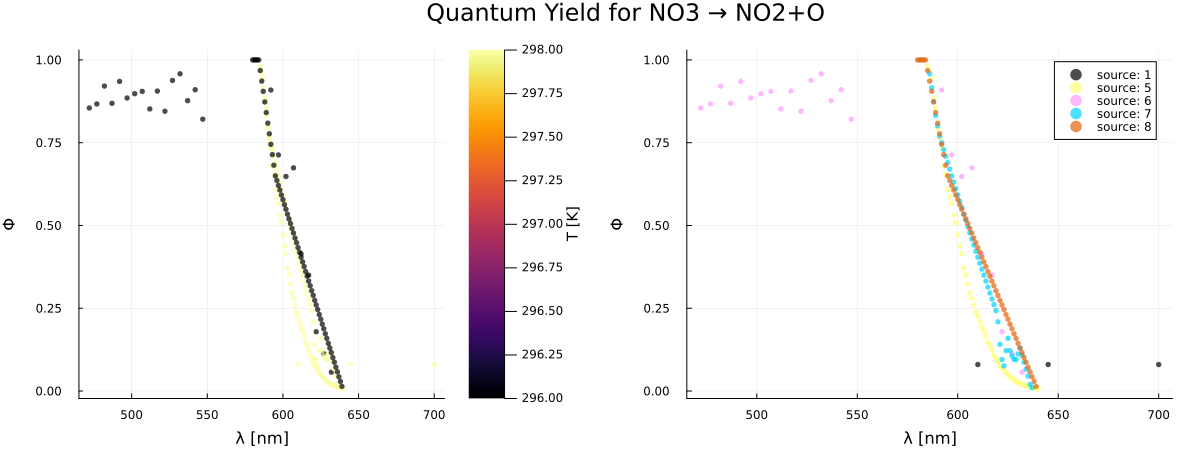

In [172]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    df.Φ[1:nskip:end],
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


gdf = groupby(df, :source_id)
p3 = plot()
i = 1
for df_g ∈ gdf 
    scatter!(
        df_g.λ[1:nskip:end],
        df_g.Φ[1:nskip:end],
        color = source_colors[i],
        ms=3, 
        msw=0,
        xlabel="λ [$(λ_units)]",
        ylabel="Φ",
        alpha=0.7,
        label="source: $(df_g.source_id[1])",
    )
    i += 1 
end

plot(p2, p3, layout=(1,2), size=(1200, 450), margin=5Plots.mm, plot_title="Quantum Yield for $(reaction)",)

In [173]:
df = df[df.source_id .!= 1 .&& df.source_id .!= 6, :]

168×4 DataFrame
 Row │ λ        Φ        T        source_id 
     │ Float64  Float64  Float64  Int64     
─────┼──────────────────────────────────────
   1 │   585.0    0.983    298.0          5
   2 │   586.0    0.967    298.0          5
   3 │   587.0    0.943    298.0          5
   4 │   588.0    0.885    298.0          5
   5 │   589.0    0.854    298.0          5
   6 │   590.0    0.793    298.0          5
   7 │   591.0    0.763    298.0          5
   8 │   592.0    0.734    298.0          5
   9 │   593.0    0.68     298.0          5
  10 │   594.0    0.654    298.0          5
  11 │   595.0    0.608    298.0          5
  ⋮  │    ⋮        ⋮        ⋮         ⋮
 159 │   630.0    0.144    296.0          8
 160 │   631.0    0.13     296.0          8
 161 │   632.0    0.116    296.0          8
 162 │   633.0    0.101    296.0          8
 163 │   634.0    0.087    296.0          8
 164 │   635.0    0.072    296.0          8
 165 │   636.0    0.058    296.0          8
 166 │   637.0    0.043    296.0          8
 167 │   638.0    0.029    296.0          8
 168 │   639.0    0.014    296.0          8
                            147 rows omitted

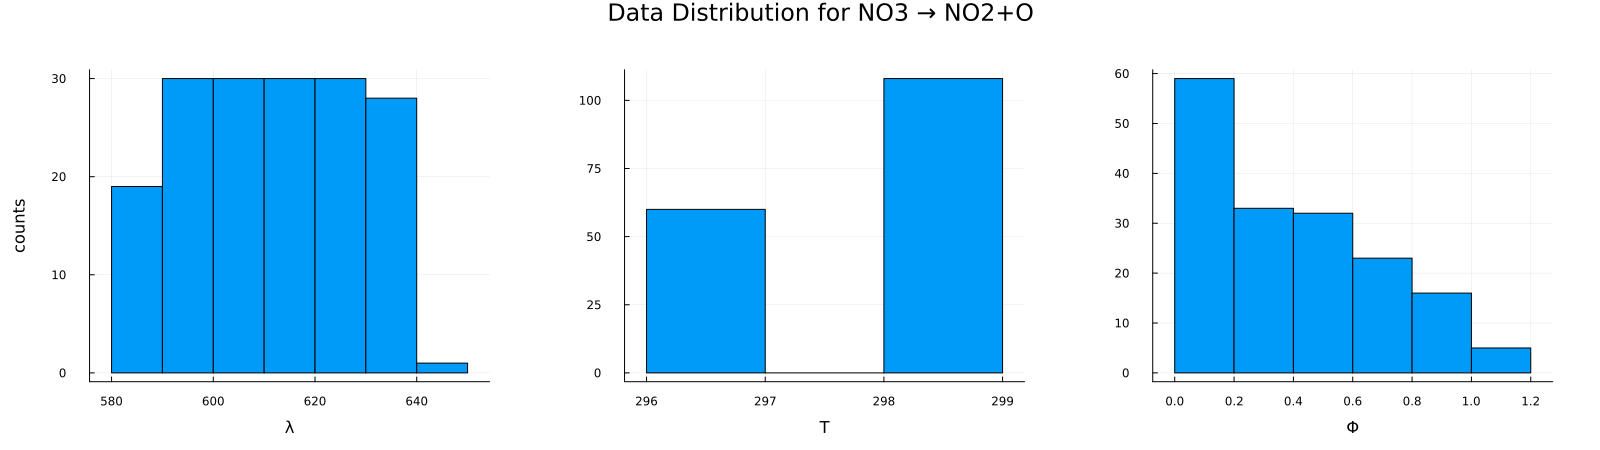

In [174]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(df.Φ, xlabel="Φ", label="", margin=10Plots.mm)
phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(reaction)")

# Data Preprocessing

In [175]:
gdfs = groupby(df, :T)

res_dfs = [] 

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:Φ, :T] .=> mean, renamecols=false))
end

df_unique = vcat(res_dfs...)

116×3 DataFrame
 Row │ λ        Φ        T       
     │ Float64  Float64  Float64 
─────┼───────────────────────────
   1 │   580.0  1.0        296.0
   2 │   581.0  1.0        296.0
   3 │   582.0  1.0        296.0
   4 │   583.0  1.0        296.0
   5 │   584.0  1.0        296.0
   6 │   585.0  0.968      296.0
   7 │   586.0  0.936      296.0
   8 │   587.0  0.905      296.0
   9 │   588.0  0.873      296.0
  10 │   589.0  0.841      296.0
  11 │   590.0  0.809      296.0
  ⋮  │    ⋮        ⋮        ⋮
 107 │   631.0  0.0768     298.0
 108 │   632.0  0.06375    298.0
 109 │   633.0  0.05235    298.0
 110 │   634.0  0.04105    298.0
 111 │   635.0  0.0298     298.0
 112 │   636.0  0.01595    298.0
 113 │   637.0  0.01035    298.0
 114 │   638.0  0.00957    298.0
 115 │   639.0  0.00856    298.0
 116 │   640.0  0.00715    298.0
                  95 rows omitted

In [176]:
# λ_idxs = representative_rand_sample(df_unique.λ, 1000, 1500)
# Φ_idxs = representative_rand_sample(df_unique.Φ, 500, 2000) 
# idxs_res = shuffle(unique(vcat(λ_idxs, σ_idxs)))
# df_sampled = df_unique[idxs_res, :]

df_sampled = df_unique
max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

580.0

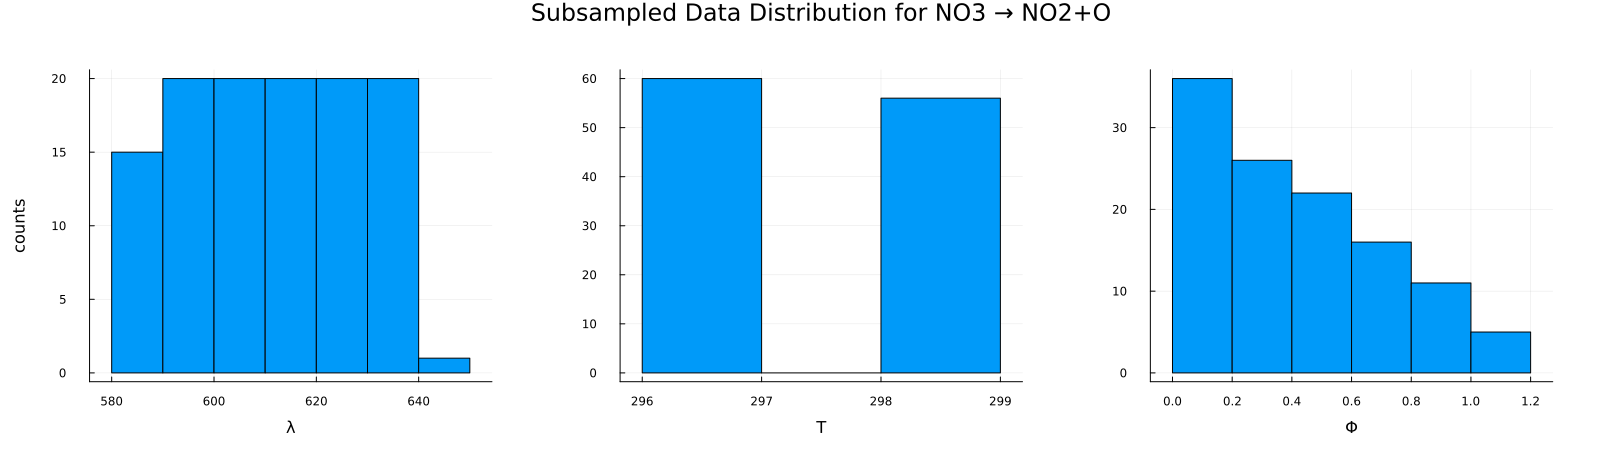

In [177]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(df_sampled.Φ, xlabel="Φ", label="", margin=10Plots.mm)

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(reaction)")

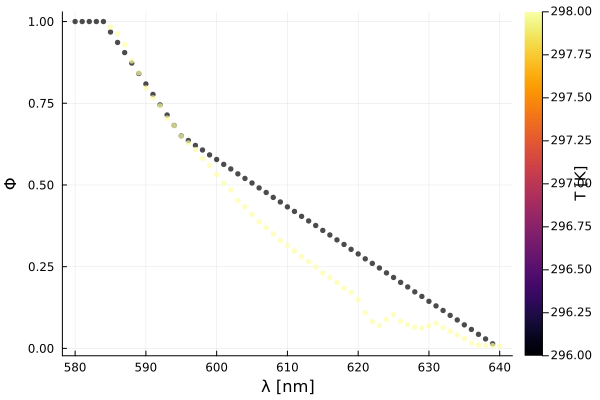

In [178]:
p2 = scatter(
    df_sampled.λ,
    df_sampled.Φ,
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    colorbar_title="T [$(T_units)]",
    label="",
)


# GPR Fit

In [179]:
train_frac = 0.95
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

110


In [180]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = df_sampled.Φ[idxs_train]
ytest = df_sampled.Φ[idxs_test]

6-element Vector{Float64}:
 0.843
 0.07680000000000001
 0.4525
 0.448
 0.116
 0.41000000000000003

In [181]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain.λ)/κ
ℓ_T = std(Xtrain.T)/κ

# compute variance parameters
SNR = 5 
σf² = var(ytrain)
σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))

# copying previously found best-fit values
θ_init = (σf²=positive(0.12318258702699822), ℓ_λ=positive(9.53983871493841), ℓ_T=positive(4.921536476898045))
σₙ² = 2.9999407129736674e-5

function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

mykernel (generic function with 1 method)

In [182]:
μ_init = 0.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = 0.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-2.0940876979066863, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(2.2554765775643486, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(1.593620770775906, exp, 1.4901161193847656e-8)), 
  σ² = 2.9999407129736674e-5, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [183]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = 0.0, …), …).


Iter     Function value   Gradient norm 
     0    -3.280327e+02     1.516442e+01
 * time: 0.00014209747314453125
     1    -3.289912e+02     2.529684e+01
 * time: 0.036216020584106445
     2    -3.301678e+02     1.088360e+01
 * time: 0.044342041015625
     3    -3.306649e+02     2.060642e+00
 * time: 0.051625967025756836
     4    -3.306788e+02     9.747471e-01
 * time: 0.05900406837463379
     5    -3.307147e+02     1.948211e+00
 * time: 0.0690450668334961
     6    -3.307482e+02     2.748618e-01
 * time: 0.07695889472961426
     7    -3.307507e+02     4.732690e-01
 * time: 0.0852499008178711
     8    -3.307543e+02     7.611923e-02
 * time: 0.09135794639587402
     9    -3.307544e+02     2.148610e-03
 * time: 0.09865593910217285
    10    -3.307544e+02     1.091245e-05
 * time: 0.10582494735717773
    11    -3.307544e+02     2.828901e-07
 * time: 0.1112210750579834
    12    -3.307544e+02     1.321321e-07
 * time: 0.11553812026977539
    13    -3.307544e+02     7.495371e-08
 * time:

trained Machine; caches model-specific representations of data
  model: GPR(μ = 0.0, …)
  args: 
    1:	Source @925 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @150 ⏎ AbstractVector{Continuous}


# Model Evaluation for pathway 2 

In [184]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [-2.072736993831673, 2.2941468414089985, 1.7883949535115247, -10.083468043792365],
 minimum = -330.7543564950946,
 iterations = 214,
 converged = false,)

In [185]:
fp =fitted_params(mach)

(θ_best = [:σf² => 0.12584089910649918, :ℓ_λ => 9.915972520211994, :ℓ_T => 5.97984684244581],
 σ² = 4.177922649333127e-5,)

In [186]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

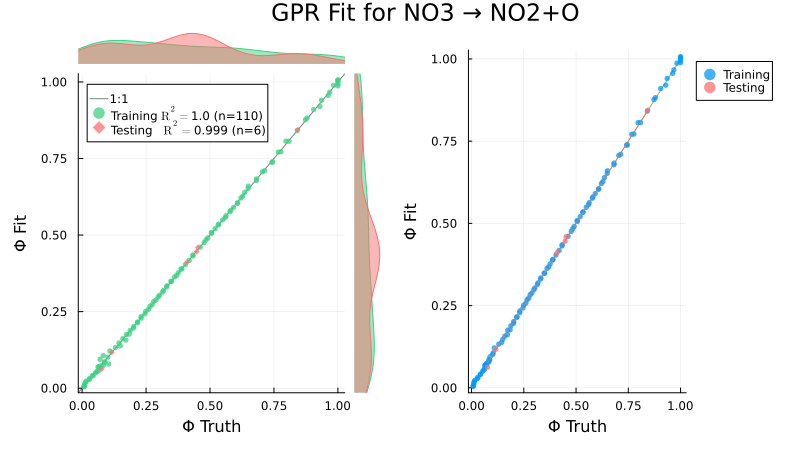

In [187]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="Φ Truth",
    ylabel="Φ Fit",
)

p2 = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="Φ Truth",
    ylabel="Φ Fit",
)

plot(p, p2, layout=(1,2), size=(800, 450), plot_title="GPR Fit for $(reaction)", margins=5Plots.mm)

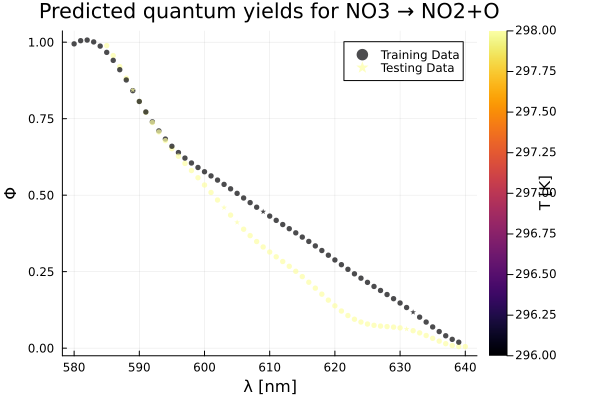

In [188]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="Φ",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted quantum yields for $(reaction)",
    label="Testing Data",
)


The note for $NO_3$ [here](http://chmlin9.leeds.ac.uk/MCMv3.3.1/parameters/photolysis.htt) specify that the QY should be $1.0$ for $\lambda \leq 580.00$ nm

580.0
640.0


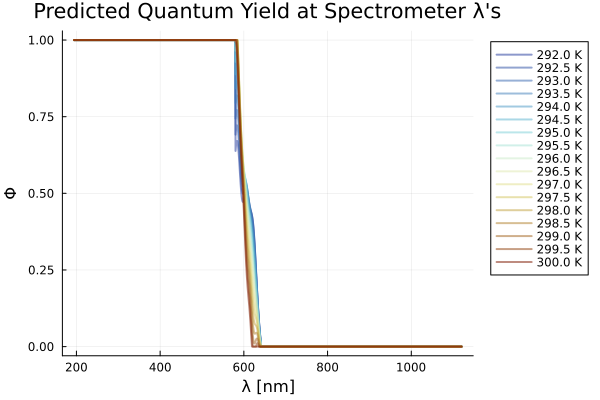

In [189]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logΦ = predict_Φ(T, hr4000_df, mach, (λ_min, λ_max))
    # update for low λ values
    idx_unity = [idx for idx ∈ 1:nrow(hr4000_df) if hr4000_df.λ[idx] <= 580.0]
    logΦ[idx_unity] .= 1.0
   
    # update for any prediction above 1.0 or below 0.0
    idx_one = [idx for idx ∈ 1:size(logΦ,1) if logΦ[idx] > 1.0]
    logΦ[idx_one] .= 1.0

    idx_zero = [idx for idx ∈ 1:size(logΦ,1) if logΦ[idx] < 0.0]
    logΦ[idx_zero] .= 0.0
    
    plot!(
        hr4000_df.λ, logΦ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("Φ")
title!("Predicted Quantum Yield at Spectrometer λ's")

# Output for Photolysis Rate Determination

In [190]:
df_photolysis_Φ = CSV.File("../photolysis_Φ.csv") |> DataFrame

3648×6 DataFrame
  Row │ Φ_1      Φ_2      Φ_3      Φ_4      Φ_6      Φ_5     
      │ Float64  Float64  Float64  Float64  Float64  Float64 
──────┼──────────────────────────────────────────────────────
    1 │     1.0      0.0      0.0      1.0      1.0      0.0
    2 │     1.0      0.0      0.0      1.0      1.0      0.0
    3 │     1.0      0.0      0.0      1.0      1.0      0.0
    4 │     1.0      0.0      0.0      1.0      1.0      0.0
    5 │     1.0      0.0      0.0      1.0      1.0      0.0
    6 │     1.0      0.0      0.0      1.0      1.0      0.0
    7 │     1.0      0.0      0.0      1.0      1.0      0.0
    8 │     1.0      0.0      0.0      1.0      1.0      0.0
    9 │     1.0      0.0      0.0      1.0      1.0      0.0
   10 │     1.0      0.0      0.0      1.0      1.0      0.0
   11 │     1.0      0.0      0.0      1.0      1.0      0.0
  ⋮   │    ⋮        ⋮        ⋮        ⋮        ⋮        ⋮
 3639 │     0.0      1.0      1.0      0.0      0.0      0.0
 3640 │     0.0      1.0      1.0      0.0      0.0      0.0
 3641 │     0.0      1.0      1.0      0.0      0.0      0.0
 3642 │     0.0      1.0      1.0      0.0      0.0      0.0
 3643 │     0.0      1.0      1.0      0.0      0.0      0.0
 3644 │     0.0      1.0      1.0      0.0      0.0      0.0
 3645 │     0.0      1.0      1.0      0.0      0.0      0.0
 3646 │     0.0      1.0      1.0      0.0      0.0      0.0
 3647 │     0.0      1.0      1.0      0.0      0.0      0.0
 3648 │     0.0      1.0      1.0      0.0      0.0      0.0
                                            3627 rows omitted

In [191]:
λ_min = minimum(df_sampled.λ)
λ_max = maximum(df_sampled.λ)

#println(λ_min, "\t", minimum(df_photolysis_σ.λ))
#println(λ_max, "\t", maximum(df_photolysis_σ.λ))

640.0

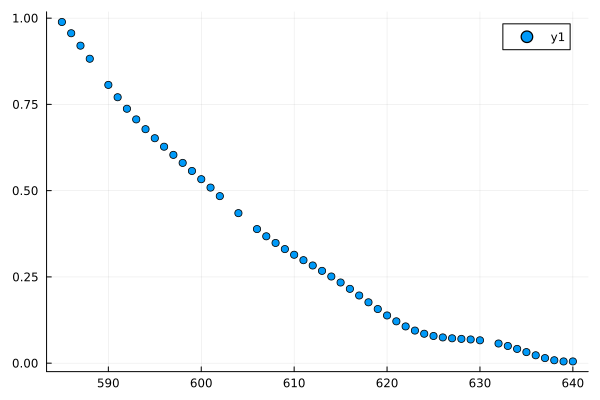

In [192]:
df_pred = sort!(Xtrain[Xtrain.T .== 298.0, :], :λ)
Φ_pred = predict_mean(mach, df_pred);

scatter(df_pred.λ, Φ_pred)

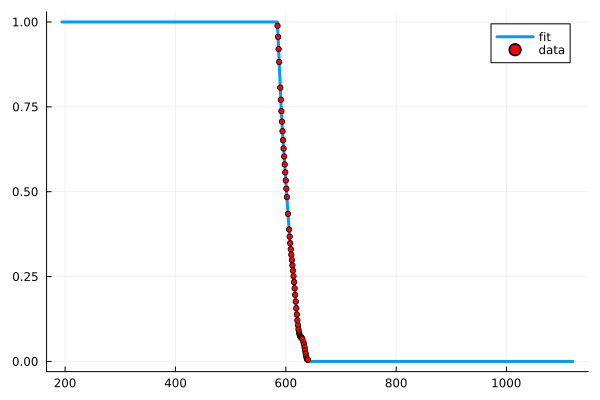

In [196]:
using DataInterpolations

cs = LinearInterpolation(Φ_pred, df_pred.λ)
Φ_out = cs(hr4000_df.λ)

# set anything outside of λ range to 0 as well
Φ_out[Φ_out .< 0.0] .= 0.0
Φ_out[ hr4000_df.λ .≥ λ_max] .= 0.0
Φ_out[hr4000_df.λ .≤ λ_min] .= 1.0
Φ_out[Φ_out .> 1.0] .= 1.0


plot(hr4000_df.λ, Φ_out, lw=3, label="fit")
scatter!(df_pred.λ, Φ_pred, color=:red, ms=3, label="data")

In [197]:
df_photolysis_Φ.Φ_6 = Φ_out

describe(df_photolysis_Φ)

6×7 DataFrame
 Row │ variable  mean        min      median   max       nmissing  eltype   
     │ Symbol    Float64     Float64  Float64  Float64   Int64     DataType 
─────┼──────────────────────────────────────────────────────────────────────
   1 │ Φ_1       0.114981        0.0      0.0  1.0              0  Float64
   2 │ Φ_2       0.885019        0.0      1.0  1.0              0  Float64
   3 │ Φ_3       0.963542        0.0      1.0  1.0              0  Float64
   4 │ Φ_4       0.214167        0.0      0.0  1.0              0  Float64
   5 │ Φ_6       0.426121        0.0      0.0  1.0              0  Float64
   6 │ Φ_5       0.00986771      0.0      0.0  0.344696         0  Float64

In [198]:
CSV.write("../photolysis_Φ.csv", df_photolysis_Φ)

"../photolysis_Φ.csv"